In [1]:
import os, sys
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Para no tener problemas de relative imports with packages
from utils import util

c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Functions
def load_raw_audios(dataframe, source, dest_root, split_name):
    '''Copies dataframe-selected audio files from source to dest_root/split_name/'''
    dest = os.path.join(dest_root, split_name)
    os.makedirs(dest, exist_ok=True)

    for _, row in dataframe.iterrows():
        primary_label = row['primary_label']
        filename = row['filename']
        
        source_path = os.path.join(source, primary_label, filename)
        destination_path = os.path.join(dest, filename)

        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)

In [3]:
# Paths
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_species.csv')) 
birdclef_dir = os.path.join('..', 'data', 'birdclef-2021', 'train_short_audio')
audio_dir = os.path.join('..', 'database', 'audio')

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# Group by author across dev/test split
def group_split(seed):
    gss = GroupShuffleSplit(
        n_splits=1, 
        test_size=0.12, # en practice termina siendo 78-22, como se ve en el print final
        random_state=seed
    )

    dev_indices, test_indices = next(gss.split(
        X=df, 
        y=df['class_id'], 
        groups=df['author']
    ))

    dev_df = df.iloc[dev_indices]
    test_df = df.iloc[test_indices]

    test_df.to_csv(os.path.join('..', 'database', 'meta', 'split_test.csv'), index=False)

    print(f"\nauthor overlap: {set(dev_df['author']) & set(test_df['author'])}")

    dev_species = set(dev_df['class_id'])
    test_species = set(test_df['class_id'])
    print(f"Species only in test: {test_species - dev_species}")
    print(f"Species only in dev: {dev_species - test_species}")
    print(f"Species in both: {len(dev_species & test_species)}")
    return dev_df, test_df


author overlap: set()
Species only in test: set()
Species only in dev: {0, 2, 5, 6, 8, 9, 10, 12, 15, 16, 17, 23}
Species in both: 17


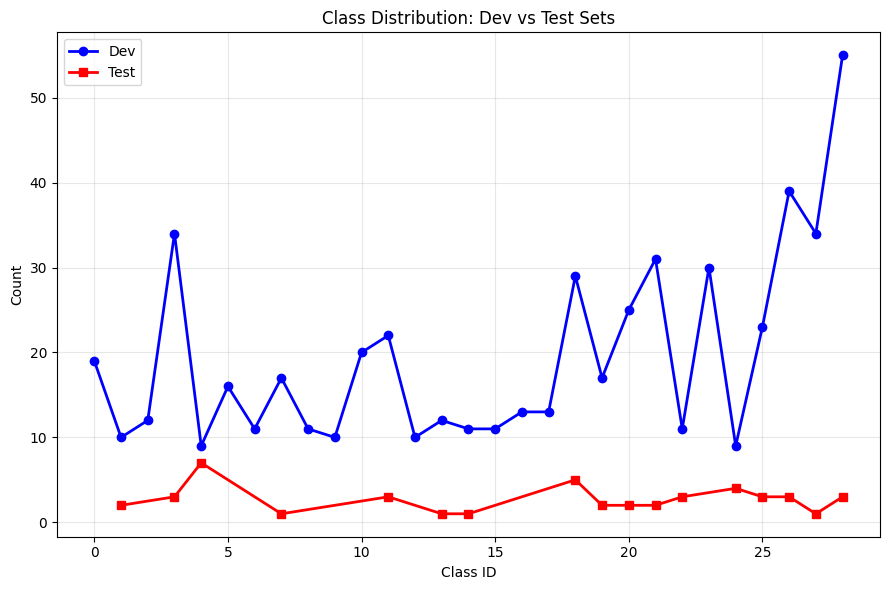

In [5]:
import matplotlib.pyplot as plt

dev_df, test_df = group_split(seed=57) # also try 50 or 55

# Calculate class counts for dev and test sets
dev_counts = dev_df['class_id'].value_counts().sort_index()
test_counts = test_df['class_id'].value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot as two separate lines
ax.plot(dev_counts.index, dev_counts.values, marker='o', linewidth=2, label='Dev', color='blue')
ax.plot(test_counts.index, test_counts.values, marker='s', linewidth=2, label='Test', color='red')

ax.set_title('Class Distribution: Dev vs Test Sets')
ax.set_xlabel('Class ID')
ax.set_ylabel('Count')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Main
util.clean_dir(audio_dir)

print("Loading Dev Files...")
load_raw_audios(dev_df, birdclef_dir, audio_dir, split_name='dev')

print("Loading Test Files...")
load_raw_audios(test_df, birdclef_dir, audio_dir, split_name='test')

Resetting ..\database\audio directory...
Loading Dev Files...
Loading Test Files...


In [7]:
# CSV with only dev species
dev_data_path = os.path.join('..', 'database', 'meta', 'dev_data.csv')
dev_files = os.listdir(os.path.join(audio_dir, 'dev'))
dev_df_filtered = dev_df[dev_df['filename'].isin(dev_files)][['filename', 'class_id', 'author']]
dev_df_filtered.to_csv(dev_data_path, index=False)

In [8]:
files_in_dev = util.count_files_in_dir(os.path.join(audio_dir, 'dev'))
files_in_test = util.count_files_in_dir(os.path.join(audio_dir, 'test'))
total_files = files_in_dev + files_in_test
dev_percentage = (files_in_dev / total_files) * 100 if total_files > 0 else 0
test_percentage = (files_in_test / total_files) * 100 if total_files > 0 else 0
print(f"Files in Dev: {files_in_dev} ({dev_percentage:.1f}%)")
print(f"Files in Test: {files_in_test} ({test_percentage:.1f}%)")

Files in Dev: 564 (92.5%)
Files in Test: 46 (7.5%)
